In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
from torch.nn.utils import clip_grad_value_
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Encoder: maps the input and label to a latent distribution.
class Encoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, latent_dim):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim) #mean of latent dist
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim) #log var of latent dist

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        h = F.relu(self.enc_fc1(combined))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

# Classifier: Predict class scores from input data.
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        logits = self.layer2(h)
        return logits

# Decoder: Maps the latent vector back to the input space.
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super().__init__()
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        combined = torch.cat([z, y], dim=-1)
        h = F.relu(self.dec_fc1(combined))
        x_hat = self.dec_fc2(h)
        return x_hat

In [3]:
# SSL model
class SSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, learning_rate):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.classifier = Classifier(input_dim, hidden_dim, num_classes)
        self.encoder = Encoder(input_dim, num_classes, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, hidden_dim, input_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def classify(self, x):
        return self.classifier(x)

    def encode(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z, y):
        return self.decoder(z, y)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_l, y_l, x_u):
        """
        x_l: labeled data
        y_l: labels
        x_u: unlabeled data

        """
        # Obtain classifier scores for labeled and unlabeled data.
        scores_l = self.classifier(x_l)
        scores_u = self.classifier(x_u)
        y_u_prob = F.softmax(scores_u, dim=1)

        # Labeled part
        y_l_onehot = F.one_hot(y_l, self.num_classes).float()
        z_l, mu_l, logvar_l = self.encode(x_l, y_l_onehot)
        x_recon = self.decode(z_l, y_l_onehot)

        # Unlabeled part
        loss_u_components = []
        for i in range(self.num_classes):
            y_u = torch.full((x_u.size(0),), i, dtype=torch.long, device=x_u.device)
            y_u_onehot = F.one_hot(y_u, self.num_classes).float()
            z_u, mu_u, logvar_u = self.encode(x_u, y_u_onehot)
            x_recon_u = self.decode(z_u, y_u_onehot)

            # Compute ELBO loss for this label.
            loss_u = self.elbo_loss(x_u, x_recon_u, mu_u, logvar_u)
            loss_u_components.append(loss_u.unsqueeze(1))

        loss_u_stack = torch.cat(loss_u_components, dim=1)

        # Weight the losses by the classifier’s predicted probabilities.
        loss_u = torch.sum(y_u_prob * (loss_u_stack + torch.log(y_u_prob + 1e-8)), dim=1)

        # Total Loss
        classification_loss = F.cross_entropy(scores_l, y_l)
        labeled_loss = self.elbo_loss(x_l, x_recon, mu_l, logvar_l)
        unlabeled_loss = loss_u.mean()

        total_loss = labeled_loss.mean() + unlabeled_loss + 0.1 * classification_loss

        return total_loss, scores_u

    def elbo_loss(self, x, x_recon, mu, logvar):
        # KL divergence between latent distribution and standard normal
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=1)
        return recon_loss + kld

    def train_step(self, x_l, y_l, x_u):
        # Training loop
        self.optimizer.zero_grad()
        loss, _ = self.forward(x_l, y_l, x_u)
        loss.backward()
        clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        # Prediction
        with torch.no_grad():
            scores = self.classifier(x)
        return torch.argmax(scores, dim=1)


In [4]:
# def prev_power_of_2(n):
#     """Returns the closest power of 2 (rounding down)"""
#     if n < 1:
#         return 1  # Ensure minimum value is at least 1 (or 2 if needed)
#     return 2 ** (n.bit_length() - 1)

## Using same number of labeled and unlabeled datasets for training

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 908kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Starting training with 100 labels...
Epoch [1/50], Average Loss: 1078.0385
Epoch [2/50], Average Loss: 1018.1943
Epoch [3/50], Average Loss: 952.8711
Epoch [4/50], Average Loss: 865.0297
Epoch [5/50], Average Loss: 772.1733
Epoch [6/50], Average Loss: 683.9331
Epoch [7/50], Average Loss: 638.2744
Epoch [8/50], Average Loss: 620.2991
Epoch [9/50], Average Loss: 572.0325
Epoch [10/50], Average Loss: 538.7998
Epoch [11/50], Average Loss: 509.5488
Epoch [12/50], Average Loss: 495.6286
Epoch [13/50], Average Loss: 489.7392
Epoch [14/50], Average Loss: 477.5423
Epoch [15/50], Average Loss: 462.7917
Epoch [16/50], Average Loss: 461.0084
Epoch [17/50], Average Loss: 443.5985
Epoch [18/50], Average Loss: 448.5306
Epoch [19/50], Average Loss: 437.5166
Epoch [20/50], Average Loss: 436.4969
Epoch [21/50], Average Loss: 441.9499
Epoch [22/50], Average Loss: 429.2535
Epoch [23/50], Average Loss: 436.5972
Epoch [24/50], Averag

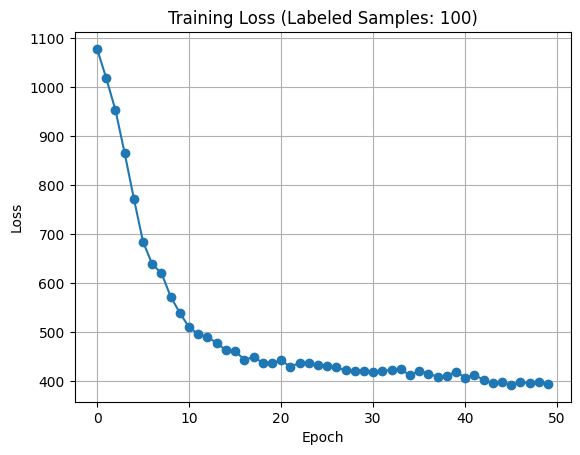

Test Accuracy (100 labels): 23.58%


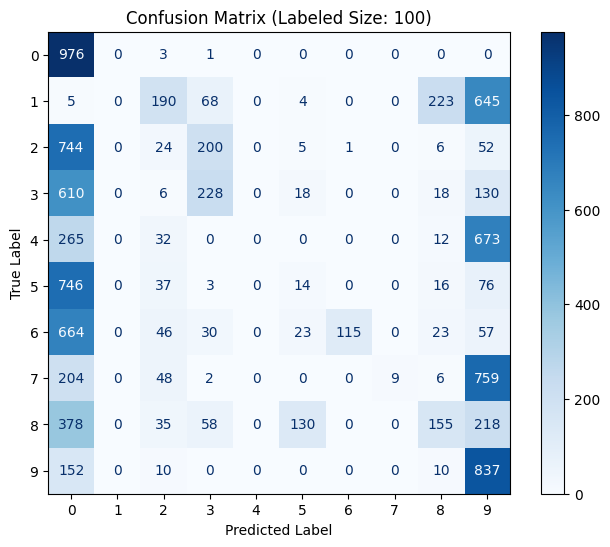

----------------------------------------------------------------
Starting training with 500 labels...
Epoch [1/50], Average Loss: 981.6007
Epoch [2/50], Average Loss: 673.1075
Epoch [3/50], Average Loss: 529.8040
Epoch [4/50], Average Loss: 472.2372
Epoch [5/50], Average Loss: 446.3534
Epoch [6/50], Average Loss: 435.2232
Epoch [7/50], Average Loss: 427.3319
Epoch [8/50], Average Loss: 421.8249
Epoch [9/50], Average Loss: 416.0771
Epoch [10/50], Average Loss: 408.0317
Epoch [11/50], Average Loss: 403.6904
Epoch [12/50], Average Loss: 400.6482
Epoch [13/50], Average Loss: 387.6669
Epoch [14/50], Average Loss: 383.5133
Epoch [15/50], Average Loss: 378.1963
Epoch [16/50], Average Loss: 369.3867
Epoch [17/50], Average Loss: 362.5913
Epoch [18/50], Average Loss: 355.1188
Epoch [19/50], Average Loss: 346.7807
Epoch [20/50], Average Loss: 344.5967
Epoch [21/50], Average Loss: 337.3576
Epoch [22/50], Average Loss: 336.1079
Epoch [23/50], Average Loss: 333.2504
Epoch [24/50], Average Loss: 325.

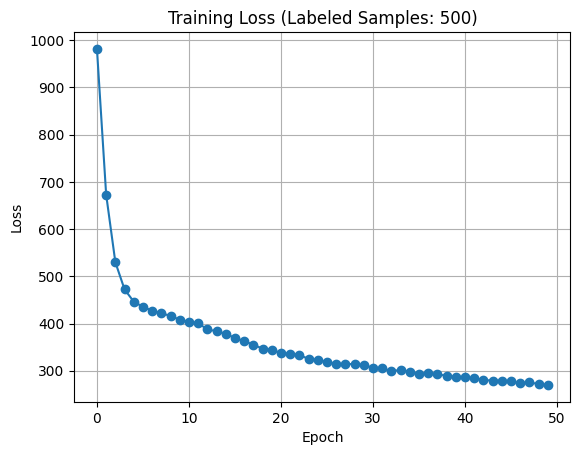

Test Accuracy (500 labels): 75.04%


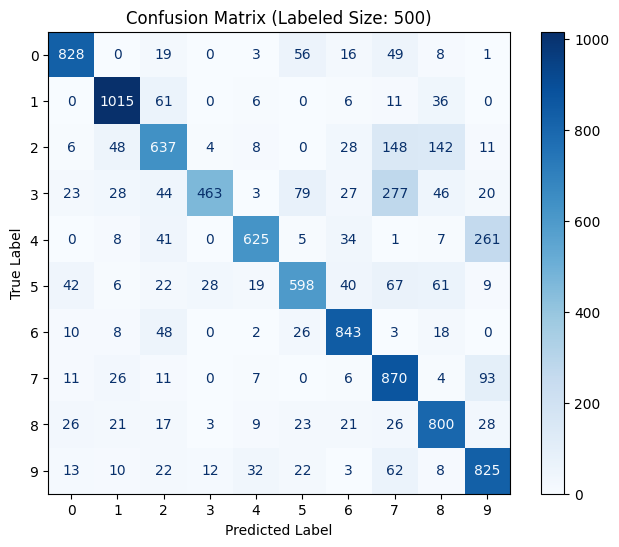

----------------------------------------------------------------
Starting training with 1000 labels...
Epoch [1/50], Average Loss: 830.0081
Epoch [2/50], Average Loss: 493.5625
Epoch [3/50], Average Loss: 438.8943
Epoch [4/50], Average Loss: 426.5007
Epoch [5/50], Average Loss: 410.0052
Epoch [6/50], Average Loss: 397.0709
Epoch [7/50], Average Loss: 379.2110
Epoch [8/50], Average Loss: 363.1521
Epoch [9/50], Average Loss: 351.5909
Epoch [10/50], Average Loss: 343.0277
Epoch [11/50], Average Loss: 330.3059
Epoch [12/50], Average Loss: 322.3373
Epoch [13/50], Average Loss: 316.6933
Epoch [14/50], Average Loss: 314.0859
Epoch [15/50], Average Loss: 309.1043
Epoch [16/50], Average Loss: 302.5097
Epoch [17/50], Average Loss: 298.4379
Epoch [18/50], Average Loss: 294.3480
Epoch [19/50], Average Loss: 296.0116
Epoch [20/50], Average Loss: 288.4109
Epoch [21/50], Average Loss: 284.9572
Epoch [22/50], Average Loss: 281.5260
Epoch [23/50], Average Loss: 281.7394
Epoch [24/50], Average Loss: 276

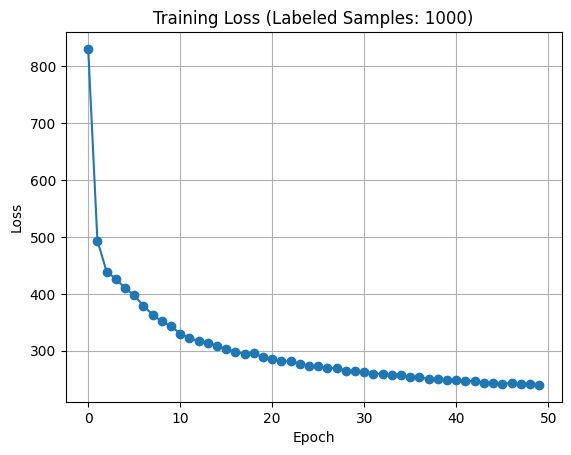

Test Accuracy (1000 labels): 80.07%


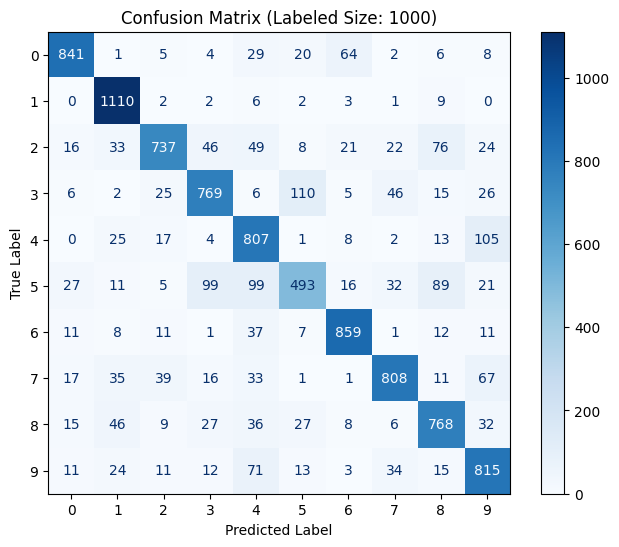

----------------------------------------------------------------
Starting training with 3000 labels...
Epoch [1/50], Average Loss: 585.6880
Epoch [2/50], Average Loss: 420.0366
Epoch [3/50], Average Loss: 374.0108
Epoch [4/50], Average Loss: 336.3844
Epoch [5/50], Average Loss: 315.9186
Epoch [6/50], Average Loss: 304.2919
Epoch [7/50], Average Loss: 293.3578
Epoch [8/50], Average Loss: 282.6832
Epoch [9/50], Average Loss: 275.8194
Epoch [10/50], Average Loss: 268.8355
Epoch [11/50], Average Loss: 263.7043
Epoch [12/50], Average Loss: 259.0680
Epoch [13/50], Average Loss: 254.7265
Epoch [14/50], Average Loss: 252.2004
Epoch [15/50], Average Loss: 250.3284
Epoch [16/50], Average Loss: 247.6923
Epoch [17/50], Average Loss: 244.2679
Epoch [18/50], Average Loss: 242.3351
Epoch [19/50], Average Loss: 241.0277
Epoch [20/50], Average Loss: 238.9349
Epoch [21/50], Average Loss: 235.9915
Epoch [22/50], Average Loss: 235.1897
Epoch [23/50], Average Loss: 232.7429
Epoch [24/50], Average Loss: 232

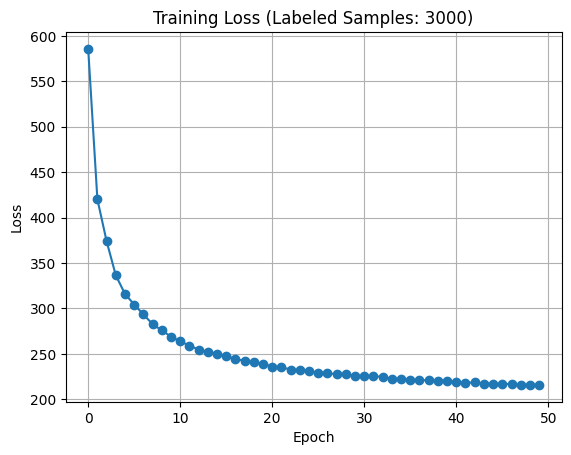

Test Accuracy (3000 labels): 86.68%


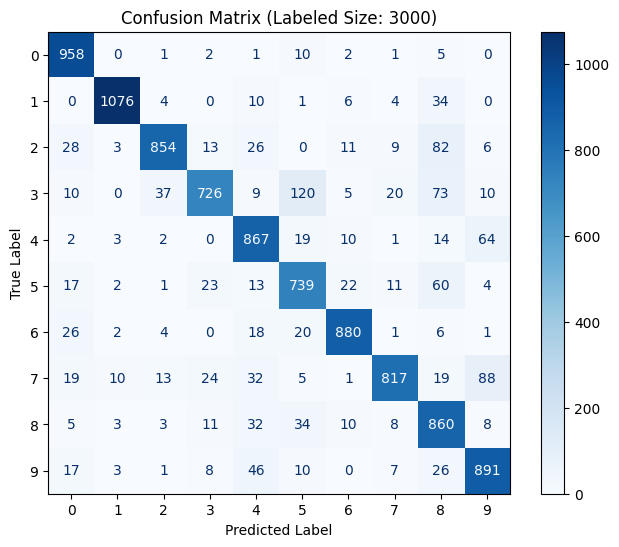

----------------------------------------------------------------
Starting training with 5000 labels...
Epoch [1/50], Average Loss: 525.8908
Epoch [2/50], Average Loss: 379.1599
Epoch [3/50], Average Loss: 325.3486
Epoch [4/50], Average Loss: 302.9143
Epoch [5/50], Average Loss: 287.6712
Epoch [6/50], Average Loss: 273.4166
Epoch [7/50], Average Loss: 263.9788
Epoch [8/50], Average Loss: 257.7915
Epoch [9/50], Average Loss: 251.1273
Epoch [10/50], Average Loss: 247.4956
Epoch [11/50], Average Loss: 243.4773
Epoch [12/50], Average Loss: 239.6767
Epoch [13/50], Average Loss: 237.1837
Epoch [14/50], Average Loss: 234.3447
Epoch [15/50], Average Loss: 231.2829
Epoch [16/50], Average Loss: 230.5332
Epoch [17/50], Average Loss: 228.4498
Epoch [18/50], Average Loss: 227.1676
Epoch [19/50], Average Loss: 226.2670
Epoch [20/50], Average Loss: 225.0259
Epoch [21/50], Average Loss: 222.8877
Epoch [22/50], Average Loss: 222.6783
Epoch [23/50], Average Loss: 220.9010
Epoch [24/50], Average Loss: 221

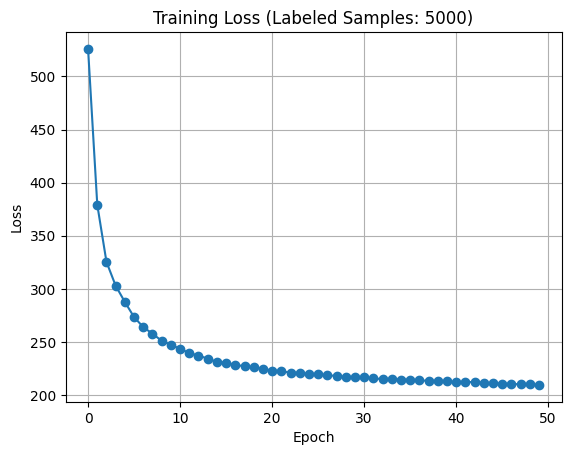

Test Accuracy (5000 labels): 91.42%


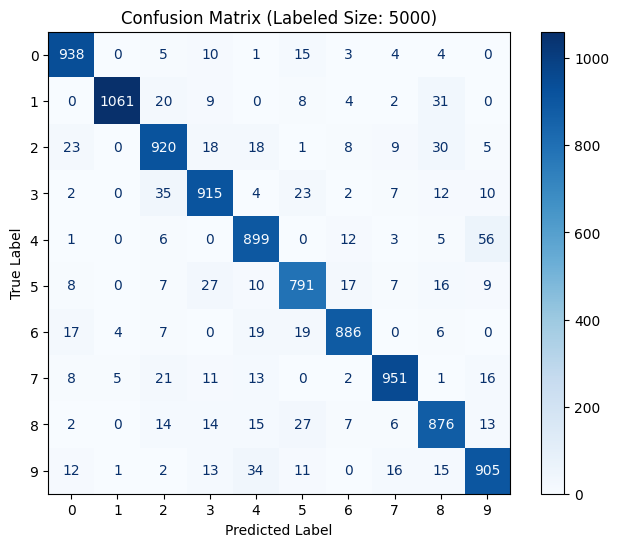

----------------------------------------------------------------


In [5]:
#Training
def main():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters.
    input_dim = 28 * 28  # MNIST images
    hidden_dim = 256
    latent_dim = 20
    num_classes = 10
    learning_rate = 1e-3
    batch_size = 64
    num_epochs = 50

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    labels_list = [100, 500, 1000, 3000, 5000] # Different label size

        # Create a semi-supervised split:

    for labeled_size in labels_list:
        # Split the dataset into labeled and unlabeled subsets randomly

        indices = torch.randperm(len(train_dataset))

        labeled_indices = indices[:labeled_size]
        unlabeled_indices = indices[labeled_size:]

        labeled_dataset = Subset(train_dataset, labeled_indices)
        unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

        labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

        model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
        model = model.to(device)
        epoch_losses = []

        # Training loop
        print(f"Starting training with {labeled_size} labels...")
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
                x_l = x_l.to(model.device)
                y_l = y_l.to(model.device)
                x_u = x_u.to(model.device)

                loss = model.train_step(x_l, y_l, x_u)
                total_loss += loss

            avg_loss = total_loss / len(labeled_loader)
            epoch_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

        # Plot training loss curve
        plt.figure()
        plt.plot(epoch_losses, marker='o')
        plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

        # Evaluate on test data.
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)  # Move test data to device
                preds = model.predict(x)
                y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU
                y_true.extend(y.numpy())

        # Calculate accuracy
        accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
        print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Confusion matrix plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap='Blues', ax=ax, values_format='d')

        ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.show()

        print('----------------------------------------------------------------')

main()

## Using all unlabeled dataset

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Starting training with 100 labels and 59900 without labels...
Epoch [1/50], Average Loss: 523.5882
Epoch [2/50], Average Loss: 404.2442
Epoch [3/50], Average Loss: 366.5784
Epoch [4/50], Average Loss: 337.8597
Epoch [5/50], Average Loss: 320.1805
Epoch [6/50], Average Loss: 309.7906
Epoch [7/50], Average Loss: 299.0186
Epoch [8/50], Average Loss: 292.9546
Epoch [9/50], Average Loss: 284.7461
Epoch [10/50], Average Loss: 278.4886
Epoch [11/50], Average Loss: 273.8998
Epoch [12/50], Average Loss: 268.3317
Epoch [13/50], Average Loss: 264.2677
Epoch [14/50], Average Loss: 262.3772
Epoch [15/50], Average Loss: 258.9451
Epoch [16/50], Average Loss: 256.0129
Epoch [17/50], Average Loss: 251.9156
Epoch [18/50], Average Loss: 251.1504
Epoch [19/50], Average Loss: 248.1299
Epoch [20/50], Average Loss: 246.3269
Epoch [21/50], Average Loss: 244.1911
Epoch [22/50], Average Loss: 241.2451
Epoch [23/50], Average Loss: 239.223

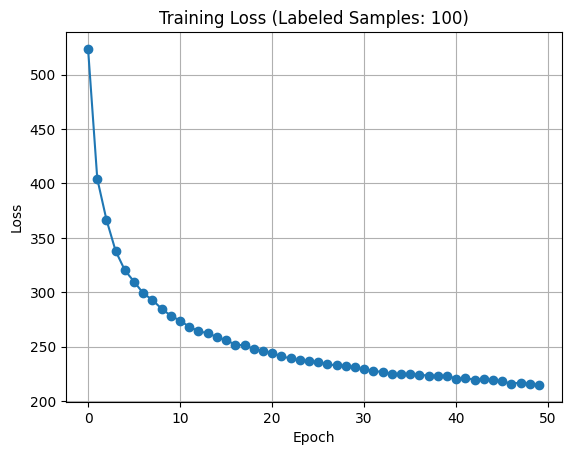

Test Accuracy (100 labels): 62.42%


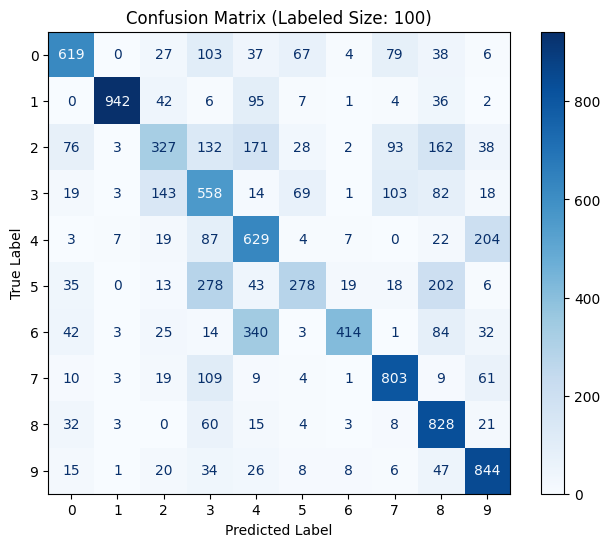

----------------------------------------------------------------
Starting training with 500 labels and 59500 without labels...
Epoch [1/50], Average Loss: 212.0537
Epoch [2/50], Average Loss: 161.9391
Epoch [3/50], Average Loss: 146.8056
Epoch [4/50], Average Loss: 142.8707
Epoch [5/50], Average Loss: 134.6079
Epoch [6/50], Average Loss: 130.8897
Epoch [7/50], Average Loss: 130.2394
Epoch [8/50], Average Loss: 126.5096
Epoch [9/50], Average Loss: 124.6551
Epoch [10/50], Average Loss: 121.5808
Epoch [11/50], Average Loss: 119.9415
Epoch [12/50], Average Loss: 118.4415
Epoch [13/50], Average Loss: 117.2938
Epoch [14/50], Average Loss: 117.1665
Epoch [15/50], Average Loss: 115.0568
Epoch [16/50], Average Loss: 114.3277
Epoch [17/50], Average Loss: 113.2584
Epoch [18/50], Average Loss: 112.4699
Epoch [19/50], Average Loss: 112.3687
Epoch [20/50], Average Loss: 111.1716
Epoch [21/50], Average Loss: 111.5722
Epoch [22/50], Average Loss: 108.7495
Epoch [23/50], Average Loss: 110.2245
Epoch [2

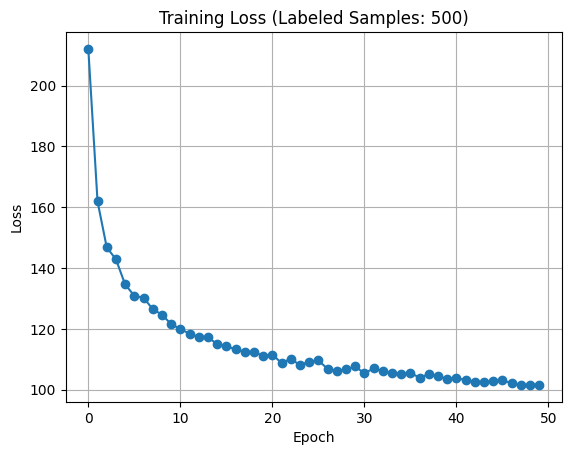

Test Accuracy (500 labels): 85.09%


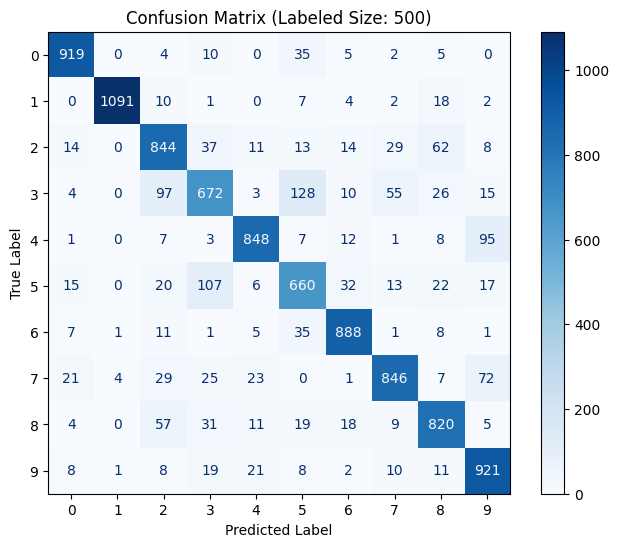

----------------------------------------------------------------
Starting training with 1000 labels and 59000 without labels...
Epoch [1/50], Average Loss: 105.5045
Epoch [2/50], Average Loss: 83.0293
Epoch [3/50], Average Loss: 74.0046
Epoch [4/50], Average Loss: 71.5194
Epoch [5/50], Average Loss: 68.6315
Epoch [6/50], Average Loss: 66.0195
Epoch [7/50], Average Loss: 64.0102
Epoch [8/50], Average Loss: 62.9508
Epoch [9/50], Average Loss: 62.2008
Epoch [10/50], Average Loss: 61.7403
Epoch [11/50], Average Loss: 60.2498
Epoch [12/50], Average Loss: 59.2751
Epoch [13/50], Average Loss: 60.1943
Epoch [14/50], Average Loss: 59.0636
Epoch [15/50], Average Loss: 57.2543
Epoch [16/50], Average Loss: 57.0481
Epoch [17/50], Average Loss: 58.0843
Epoch [18/50], Average Loss: 57.6922
Epoch [19/50], Average Loss: 56.8847
Epoch [20/50], Average Loss: 56.6781
Epoch [21/50], Average Loss: 55.7697
Epoch [22/50], Average Loss: 55.0493
Epoch [23/50], Average Loss: 55.9397
Epoch [24/50], Average Loss: 

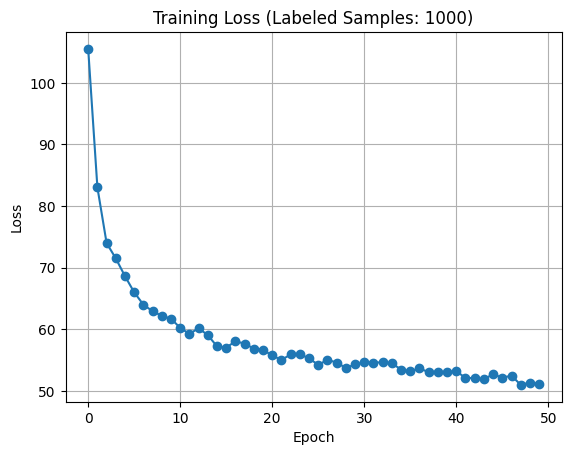

Test Accuracy (1000 labels): 87.28%


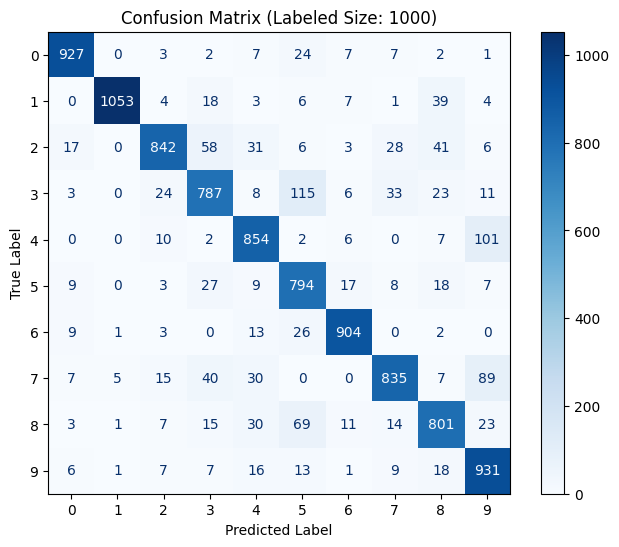

----------------------------------------------------------------
Starting training with 3000 labels and 57000 without labels...
Epoch [1/50], Average Loss: 33.8915
Epoch [2/50], Average Loss: 25.7545
Epoch [3/50], Average Loss: 23.4247
Epoch [4/50], Average Loss: 22.5479
Epoch [5/50], Average Loss: 21.8230
Epoch [6/50], Average Loss: 21.2815
Epoch [7/50], Average Loss: 20.9144
Epoch [8/50], Average Loss: 20.7022
Epoch [9/50], Average Loss: 19.9005
Epoch [10/50], Average Loss: 19.9156
Epoch [11/50], Average Loss: 19.6605
Epoch [12/50], Average Loss: 19.2900
Epoch [13/50], Average Loss: 19.2828
Epoch [14/50], Average Loss: 19.1485
Epoch [15/50], Average Loss: 18.8789
Epoch [16/50], Average Loss: 18.7264
Epoch [17/50], Average Loss: 17.9806
Epoch [18/50], Average Loss: 18.3617
Epoch [19/50], Average Loss: 18.5815
Epoch [20/50], Average Loss: 18.4764
Epoch [21/50], Average Loss: 18.4278
Epoch [22/50], Average Loss: 18.0578
Epoch [23/50], Average Loss: 17.8749
Epoch [24/50], Average Loss: 1

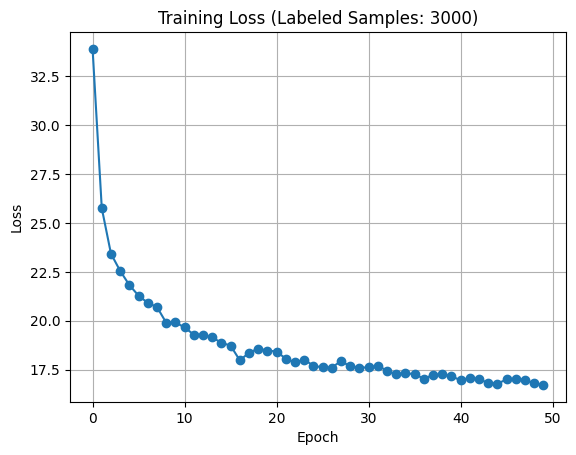

Test Accuracy (3000 labels): 89.70%


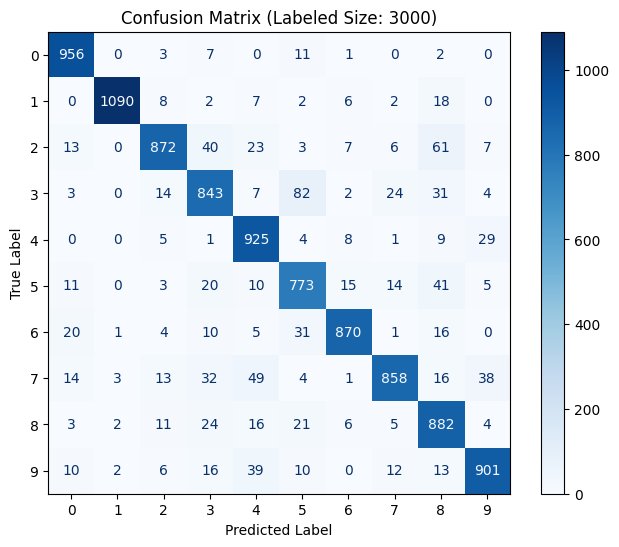

----------------------------------------------------------------
Starting training with 5000 labels and 55000 without labels...
Epoch [1/50], Average Loss: 19.6650
Epoch [2/50], Average Loss: 15.4485
Epoch [3/50], Average Loss: 14.1307
Epoch [4/50], Average Loss: 13.5524
Epoch [5/50], Average Loss: 12.8645
Epoch [6/50], Average Loss: 12.9309
Epoch [7/50], Average Loss: 12.5027
Epoch [8/50], Average Loss: 12.0683
Epoch [9/50], Average Loss: 11.9561
Epoch [10/50], Average Loss: 11.7806
Epoch [11/50], Average Loss: 11.5743
Epoch [12/50], Average Loss: 11.4753
Epoch [13/50], Average Loss: 11.3664
Epoch [14/50], Average Loss: 11.2135
Epoch [15/50], Average Loss: 11.2135
Epoch [16/50], Average Loss: 10.9205
Epoch [17/50], Average Loss: 10.9972
Epoch [18/50], Average Loss: 10.9347
Epoch [19/50], Average Loss: 10.7099
Epoch [20/50], Average Loss: 10.4706
Epoch [21/50], Average Loss: 10.4509
Epoch [22/50], Average Loss: 10.7896
Epoch [23/50], Average Loss: 10.5750
Epoch [24/50], Average Loss: 1

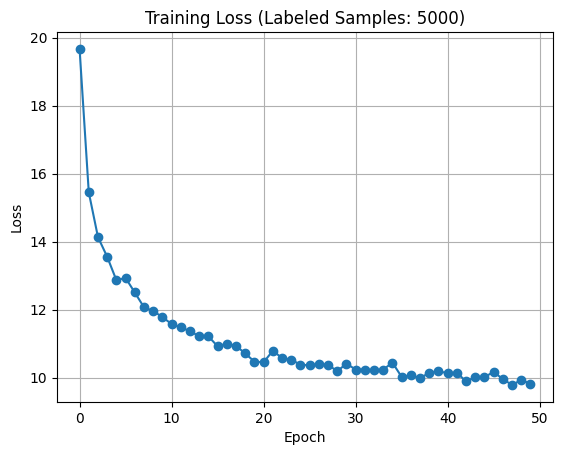

Test Accuracy (5000 labels): 90.24%


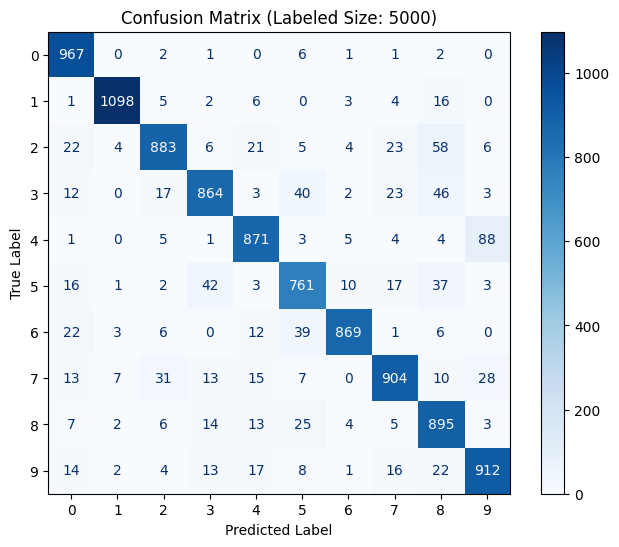

----------------------------------------------------------------


In [4]:
%timeit
def main1():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters.
    input_dim = 28 * 28  # MNIST images
    hidden_dim = 256
    latent_dim = 20
    num_classes = 10
    learning_rate = 1e-3
    batch_size = 256
    num_epochs = 50

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    labels_list = [100, 500, 1000, 3000, 5000] # Different label size

        # Create a semi-supervised split:

    for labeled_size in labels_list:
        # Split the dataset into labeled and unlabeled subsets randomly

        unlabeled_size = len(train_dataset) - labeled_size # find the unlabeled dataset size
        batch_size_labeled =  max(1, (labeled_size // unlabeled_size)) #* prev_power_of_2(batch_size * # ensure proportional ratio of batches for labeled and unlabeled

        indices = torch.randperm(len(train_dataset))

        labeled_indices = indices[:labeled_size]
        unlabeled_indices = indices[labeled_size:]

        labeled_dataset = Subset(train_dataset, labeled_indices)
        unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

        labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, pin_memory=True)
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

        model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
        model = model.to(device)
        epoch_losses = []

        # Training loop
        print(f"Starting training with {labeled_size} labels and {unlabeled_size} without labels...")
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            num_batches = 0
            labeled_samples_count = 0
            unlabeled_samples_count = 0

            for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
                # # Update counters
                # num_batches += 1
                # labeled_samples_count += x_l.size(0)
                # unlabeled_samples_count += x_u.size(0)

                x_l = x_l.to(device)
                y_l = y_l.to(device)
                x_u = x_u.to(device)

                loss = model.train_step(x_l, y_l, x_u)
                total_loss += loss

            avg_loss = total_loss / len(labeled_loader)
            epoch_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
            #print(f"  Processed {num_batches} batches: {labeled_samples_count} labeled samples, {unlabeled_samples_count} unlabeled samples")

        # Plot training loss curve
        plt.figure()
        plt.plot(epoch_losses, marker='o')
        plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

        # Evaluate on test data.
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                preds = model.predict(x)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        # Calculate accuracy
        accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
        print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Confusion matrix plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap='Blues', ax=ax, values_format='d')

        ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.show()

        print('----------------------------------------------------------------')

main1()
